In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_csv('Data/insurance - insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Question 1

Null Hypothesis: Smokers and non-smokers have the same insurance charges.\
Alternative Hypothesis: Smokers have higher insurance charges than non-smokers.\
This question calls for a 2 Sample T-Test.

In [4]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [5]:
smokers = df.loc[df['smoker']== 'no'].copy()
non_smokers = df.loc[df['smoker']== 'yes'].copy()

In [6]:
smokers_charges = smokers['charges']
non_smokers_charges = non_smokers['charges']

In [7]:
# Check for outliers in charges for smoker group
zscores= stats.zscore(smokers_charges)
outliers = abs(zscores)>3
np.sum(outliers)

24

In [8]:
# remove outliers from smoker group
smokers_charges = smokers_charges[(np.abs(stats.zscore(smokers_charges)) < 3)]

In [9]:
# Check for outliers in charges for non-smoker group
zscores= stats.zscore(smokers_charges)
outliers = abs(zscores)>3
np.sum(outliers)

19

In [10]:
# remove outliers from non_smoker group
non_smokers_charges = non_smokers_charges[(np.abs(stats.zscore(non_smokers_charges)) < 3)]

In [11]:
# test the strength group for normality
result_smokers_charges = stats.normaltest(smokers_charges)
result_smokers_charges

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

In [12]:
result_non_smokers_charges = stats.normaltest(non_smokers_charges)
result_non_smokers_charges

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [13]:
# Test for equal variance
result = stats.levene(smokers_charges, non_smokers_charges)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

In [14]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(smokers_charges, non_smokers_charges, equal_var = False)
result

Ttest_indResult(statistic=-33.732305987092516, pvalue=2.575322662587431e-104)

The p-value is well below 0.05 so we can reject the null hypothesis. Smokers have higher insurance charges than non-smokers.

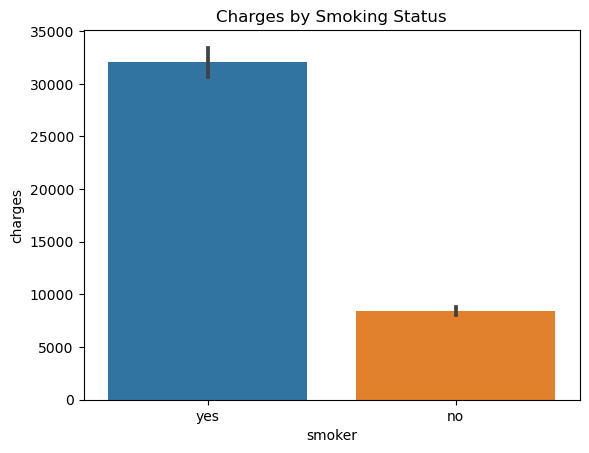

In [15]:
ax = sns.barplot(data=df, x='smoker',y='charges',)
ax.set_title("Charges by Smoking Status");

# Question 2

Null Hypothesis: Men and women smoke the same amount.\
Alternative Hypothesis: Men smoke more than women.\
This question calls for a Chi-Square Test.

In [16]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [17]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [18]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

The p-value is far less than  0.05, so we can reject the null hypothesis. Sex does seem to have some effect on whether or not someone smokes.

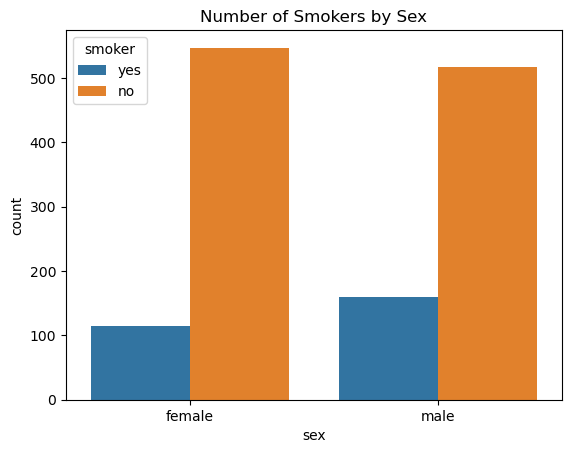

In [19]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");

# Question 3

Null Hypothesis: Different regions have the same charges.\
Alternative Hypothesis: Different regions have different charges.\
This question calls for an ANOVA and/or Tukey Test

In [20]:
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [21]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [22]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [23]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [24]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

In [25]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df['charges']
labels = df['region']

In [26]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


We can reject the null hypothesis. There is a significant difference in charges between the southeast and southwest regions.

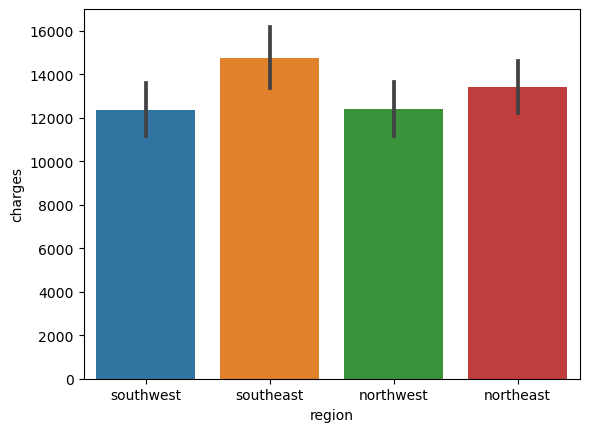

In [27]:
sns.barplot(data=df, x='region',y='charges');